In [139]:
import pandas as pd

In [140]:
data = pd.read_csv("SBAnational.csv")

In [141]:
df = data.sample(n = 10000,random_state=42)

In [142]:
def cleaning(df):


    # Columns Selection
    df = df.drop(columns=['Name', 'LoanNr_ChkDgt', 'Bank', 
                     'BankState', 'DisbursementDate', 'ApprovalDate', 
                    'ApprovalFY', 'FranchiseCode', 'Zip', 'City', 'ChgOffDate', 'SBA_Appv', 'BalanceGross', 'DisbursementGross', 'ChgOffPrinGr'])
    # Deal with NA
    df = df.dropna(subset=['MIS_Status']) 

    # Data formating for training data (outside pipe)
    df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')    
    df['RevLineCr'] = df['RevLineCr'].mask(df.RevLineCr.isin(['0','T','1','R','`','2','C','3',',','7','A','5','.','4','-','Q']))   
    df['LowDoc'] = df['LowDoc'].mask(df.LowDoc.isin(['0','C','S','A','R','1'])) 
    df['NewExist'] = df['NewExist'].replace({2:False, 1:True})   
    df['NAICS'] = df['NAICS'].astype('str').apply(lambda x : x[:2])    
    return df

df = cleaning(df)

In [143]:

from sklearn.model_selection import train_test_split
y = df['MIS_Status'].replace({'P I F':0, 'CHGOFF':1}) 
X = df.drop(['MIS_Status'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False,test_size=0.2, random_state=42)



In [144]:
numeric_features = list(X.select_dtypes(include=['int', 'float']).columns)
len(numeric_features)

6

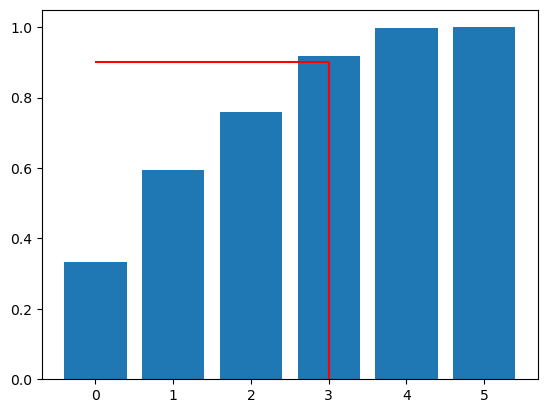

In [145]:
from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_transformer = Pipeline([
        ('standard', StandardScaler()),  # Centrer réduire
        ('pca', PCA(n_components=4)) # après standardisation
        ])


# ############### IV.c Categorial features ##############
categorial_features = ['RevLineCr', 'LowDoc', 'NewExist', 'NAICS', 'State']

from sklearn.preprocessing import OneHotEncoder
categorical_transformer = OneHotEncoder(sparse=True)



# ############### IV.d Combinaison ##############
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ],
    remainder="passthrough" 
)


############### IV.d Estimator ##############
from xgboost import XGBClassifier
xg = XGBClassifier(max_depth = 5 , learning_rate = 0.125,scale_pos_weight = 1.75,random_state = 42)


# ############### IV.d Final_pipe ##############

from sklearn.pipeline import Pipeline
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', xg)
])

In [147]:
from run_experiment import run_experiment

In [148]:
from sklearn.model_selection import KFold

# define evaluation
cv = KFold(n_splits=5, random_state=42,shuffle = True)

# ############### V.c Hyparameters space setting ##############

# import numpy as np

positives = sum(y) / len(y)
negatives = 1 - positives
scale_ratio = negatives / positives

space = {'clf__max_depth' : [5],
              'clf__learning_rate' : [0.125],
              
              
              'clf__scale_pos_weight' : [1.75]
              }

# ############### V.d RandomSearch and GridSearc ##############


from sklearn.model_selection import GridSearchCV
model = GridSearchCV(
    pipe,
    space,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    cv=cv
)


In [149]:


import mlflow

experiment_id = mlflow.get_experiment_by_name("experiment").experiment_id



In [150]:
with mlflow.start_run(experiment_id=experiment_id) as run:
    model_fit = run_experiment(X_train,y_train,X_test,y_test,model, "classification")

    for param,value in model_fit["clf"].get_params().items():
        mlflow.log_param(param, value)
    mlflow.log_param("PCA", True) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__learning_rate=0.125, clf__max_depth=5, clf__scale_pos_weight=1.75; total time=   1.3s
[CV] END clf__learning_rate=0.125, clf__max_depth=5, clf__scale_pos_weight=1.75; total time=   1.2s
[CV] END clf__learning_rate=0.125, clf__max_depth=5, clf__scale_pos_weight=1.75; total time=   1.4s
[CV] END clf__learning_rate=0.125, clf__max_depth=5, clf__scale_pos_weight=1.75; total time=   1.3s
[CV] END clf__learning_rate=0.125, clf__max_depth=5, clf__scale_pos_weight=1.75; total time=   1.5s
Best Hyperparameters: {'clf__learning_rate': 0.125, 'clf__max_depth': 5, 'clf__scale_pos_weight': 1.75}
######## accuracy_score : 
TRAIN : 0.9080100125156445
TEST : 0.8653653653653653
######## f1_score : 
TRAIN : 0.7219069239500567
TEST : 0.6162624821683309
######## precision_score : 
TRAIN : 0.7383900928792569
TEST : 0.6545454545454545
######## recall_score : 
TRAIN : 0.7061435973353072
TEST : 0.5822102425876011
######## roc_auc_score :

In [151]:
import warnings
warnings.filterwarnings('ignore')
############### V.f LearningCurve ##############

best_model_params = model_fit["clf"].get_params()
xg_best = XGBClassifier(**best_model_params)
best_pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', xg_best)
])

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

N, train_score, val_score = learning_curve(best_pipe, X_train, y_train,cv=cv)


[ 639 2077 3515 4953 6392]


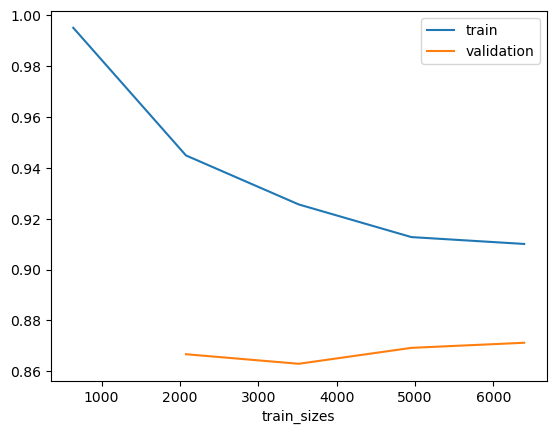

In [152]:


print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

